In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomContrast, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1, l2
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import datetime

In [59]:
# Set variables
epoch = 3
batch_size = 16
target_size = (299, 299)

# Load and preprocess images
def load_and_preprocess_images(data_df, image_folder, target_size):
    X = []
    y = []

    for index, row in data_df.iterrows():
        img_filename = row['image_path'][1:]  # Remove leading "/"
        img_path = os.path.join(image_folder, img_filename)
        label = row['label'] - 1

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, target_size)
        img = img / 255.0

        X.append(img)
        y.append(label)

    return np.array(X), np.array(y)

In [4]:
# Load train data
train_df = pd.read_csv("train_images.csv")
script_dir = os.getcwd()
train_images = os.path.join(script_dir, 'train_images')

X_train, y_train = load_and_preprocess_images(train_df, script_dir, target_size)

# Shuffle the data
X_train, y_train = shuffle(X_train, y_train, random_state=42)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

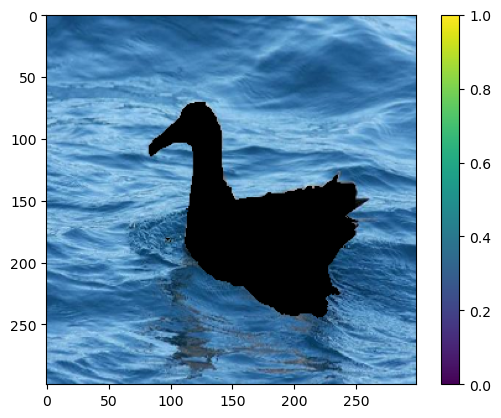

(<matplotlib.image.AxesImage at 0x2d2738cd0>,
 None)

In [45]:
# Graph cut

import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

path_to_code = '/Users/jaimeponsgarrido/Downloads/BIRDeep/code/'
img_filename = train_df['image_path'][0]  # Remove leading "/"
img_path = path_to_code + img_filename

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, target_size)
mask = np.zeros(img.shape[:2],np.uint8)
bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)
rect = (50,50,200,200)
cv.grabCut(img,mask,rect,bgdModel,fgdModel,5,cv.GC_INIT_WITH_RECT)
mask_figure = np.where((mask==2)|(mask==0),0,1).astype('uint8')
mask_background = np.where((mask==2)|(mask==0),1,0).astype('uint8')
img_figure = img*mask_figure[:,:,np.newaxis]
img_background = img*mask_background[:,:,np.newaxis]
img_figure = img_figure / 255.0
img_background = img_background / 255.0
plt.imshow(img_background),plt.colorbar(),plt.show()


In [61]:
# Load and preprocess images
def background_extractor(data_df, image_folder, target_size):
    figure = []
    background = []
    y = []
    for index, row in data_df.iloc[:500,:].iterrows():
        img_filename = row['image_path'][1:]  # Remove leading "/"
        img_path = os.path.join(image_folder, img_filename)
        label = row['label'] - 1

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, target_size)
        mask = np.zeros(img.shape[:2],np.uint8)
        bgdModel = np.zeros((1,65),np.float64)
        fgdModel = np.zeros((1,65),np.float64)
        rect = (50,50,200,200)
        cv.grabCut(img,mask,rect,bgdModel,fgdModel,5,cv.GC_INIT_WITH_RECT)
        mask_figure = np.where((mask==2)|(mask==0),0,1).astype('uint8')
        mask_background = np.where((mask==2)|(mask==0),1,0).astype('uint8')
        img_figure = img*mask_figure[:,:,np.newaxis]
        img_background = img*mask_background[:,:,np.newaxis]
        img_figure = img_figure / 255.0
        img_background = img_background / 255.0
        figure.append(img_figure)
        background.append(img_background)
        y.append(label)

    return np.array(figure), np.array(background), np.array(y)

In [62]:


figure_train, background_train, y_train = background_extractor(train_df, script_dir, target_size)


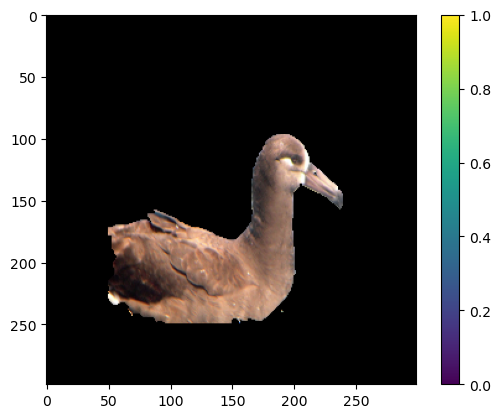

(<matplotlib.image.AxesImage at 0x7205fa310>,
 None)

In [63]:
plt.imshow(figure_train[12]),plt.colorbar(),plt.show()

In [64]:
# Shuffle the data
X_train, y_train = shuffle(figure_train, y_train, random_state=42)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(figure_train, y_train, test_size=0.2, random_state=42)

In [65]:
# Model architecture
base_model = tf.keras.applications.xception.Xception(weights="imagenet", include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
dropout = Dropout(0.5)(avg) 
output = tf.keras.layers.Dense(200, activation="softmax")(dropout)
model = tf.keras.Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers:
    layer.trainable = False
    
# Compile the model
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

# Implement early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [66]:
# Train the model with early stopping
model.fit(
    X_train,
    y_train,
    epochs=epoch,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping] 
)

Epoch 1/3
13/13 [==============================] - 9s 592ms/step - loss: 4.0769 - accuracy: 0.0525 - val_loss: 3.0130 - val_accuracy: 0.0400
Epoch 2/3
13/13 [==============================] - 6s 441ms/step - loss: 2.9056 - accuracy: 0.0875 - val_loss: 2.9312 - val_accuracy: 0.0700
Epoch 3/3
13/13 [==============================] - 6s 469ms/step - loss: 2.7695 - accuracy: 0.1000 - val_loss: 2.8997 - val_accuracy: 0.0500


In [ ]:

# Load test data paths
test_df = pd.read_csv("test_images_path.csv")
test_images = os.path.join(script_dir, 'test_images')
X_test, _ = load_and_preprocess_images(test_df, test_images, target_size)

In [ ]:
# Make predictions
predictions = model.predict(X_test)

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1) + 1

# Update the 'label' column in the test dataframe with the predicted labels
test_df['label'] = predicted_labels

selected_columns = ['id', 'label']
test_df_selected = test_df[selected_columns]

# Generate a timestamp for the filename
current_datetime = datetime.datetime.now()
timestamp = current_datetime.strftime("%Y%m%d_%H%M")
file_name = f"submission_{timestamp}.csv"

# Define the folder for submissions
submissions_folder = os.path.join(script_dir, 'submissions')

# Specify the full file path
file_path = os.path.join(submissions_folder, file_name)

# Save the final submission file
test_df_selected.to_csv(file_path, index=False)